# Program used for transitions of elongation rates, fluorescence intensities and fluorescence ratio in generations

This program are used in Figure 1D and E, 2H and I, S4, S5 and S10. 

### import packages

In [1]:
import numpy as np
import pandas as pd 
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import glob
from common_function import singlecell as sc

### Matplotlib setting

In [2]:
plt.rcParams['text.usetex'] = True 
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams["font.size"] = 16.0

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

## Figure 1D

### set variables

In [3]:
path_list = ['./single-cell_data/deletion_in_no_Cp/190107']
branch_path = path_list[0]
BL_time_Cp_time_list = pd.read_csv('./BL_time_Cp_time_data.csv')
BL_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(branch_path[-6:]), 'BL_time'].reset_index(drop = True)[0] ## slice number just after blue light exposure
Cp_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(branch_path[-6:]), 'Cp_time'].reset_index(drop = True)[0] ## slice number just after Cp exposure
if BL_time == 0:
    BL_time = Cp_time
window = 1/12 ## averaged time window (1/12 is non-averaged window)

### import and modify the Results data

In [4]:
image_path = branch_path
Number = os.listdir(image_path + '/integrated')
Number = [i for i in Number if 'Results' in i]
for i in range(len(Number)):
    Number[i] = Number[i].lstrip('Results')
    Number[i] = Number[i].rstrip('.csv')
Result_all = sc.Read_results_data(Number, dr = image_path)      

Result_all = Result_all[(Result_all['Slice']<=BL_time-4)|(Result_all['Slice']>=BL_time)] #exclude the data during BL illumination
Result_gen = sc.Modify_generation_data(Result_all,BL_time)
Result_gen.file = Result_gen.file.astype(str).str.zfill(4)

### calculate the averaged fluorescence intensities of mCherry-CAT
res_gen = Result_gen.groupby(['file', 'Division_number'], as_index = False).agg({'TxRed': 'mean'}).copy()
res_gen['id_number'] = Result_gen.groupby(['file', 'Division_number'], as_index = False).id_number.mean().reset_index()['id_number']

### Distinguish the total data by cell types

In [5]:
res_gen0 = res_gen[res_gen['id_number']==0].groupby('Division_number').TxRed.describe().reset_index() # select resistance-gene-deleted cell lineages
res_gen2 = res_gen[res_gen['id_number']==2].groupby('Division_number').TxRed.describe().reset_index() # select non-deleted cell lineages

### calculate dilution line

In [6]:
base = res_gen0.loc[list(res_gen0.query('Division_number == 0').index)[0],'50%']
a = np.arange(0,21,1)
b = np.ones(21)*2
dilution = 1/np.power(b,a)

### plot and save figure

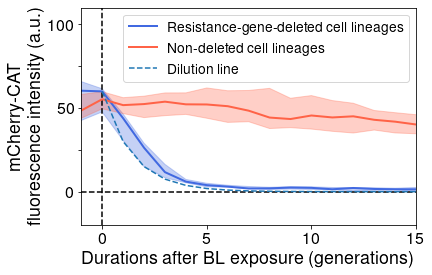

In [7]:
fig, axes = plt.subplots(ncols = 1, nrows = 1,figsize = (6,4))
res_gen0[res_gen0['count']>=np.max(res_gen0['count'])/5.0].plot(x = 'Division_number',y = '50%',ax = axes,color = 'royalblue',lw = 2, label = 'Resistance-gene-deleted cell lineages')
res_gen2.plot(x = 'Division_number',y = '50%',ax = axes,color = 'tomato',lw = 2, label = 'Non-deleted cell lineages')
axes.plot(a,dilution*base, linestyle = '--', label = 'Dilution line')
axes.legend(fontsize = 14.0, loc = 'upper right', bbox_to_anchor = (1.00,1.00))

axes.fill_between(res_gen0[res_gen0['count']>=np.max(res_gen0['count'])/5.0]['Division_number'],res_gen0[res_gen0['count']>=np.max(res_gen0['count'])/5.0]['25%'],res_gen0[res_gen0['count']>=np.max(res_gen0['count'])/5.0]['75%'],color = 'royalblue', alpha = 0.3)
axes.fill_between(res_gen2['Division_number'],res_gen2['25%'],res_gen2['75%'],color = 'tomato', alpha = 0.3)
axes.vlines(0,-20,110,linestyle = 'dashed')
axes.hlines(0,-1,15,linestyle = 'dashed')
axes.set_xlim(-1,15)
axes.set_ylim(-20,110)
axes.set_xticks([0,5,10,15])
axes.set_xticklabels(['0','5','10','15'])
axes.set_yticks([0,25,50,75,100])
axes.set_yticklabels(['0','','50','','100'])

plt.xlabel('Durations after BL exposure (generations)',fontsize = 18.0)
plt.ylabel('mCherry-CAT\n fluorescence intensity (a.u.)',fontsize = 18.0)
plt.show()
# save_path = './Figure_1_D.pdf'
# plt.savefig(save_path, transparent = True, bbox_inches = 'tight')
# plt.cla()

## Figure 1E

### import generation time data and divide the data among cell type and before/after BL.

In [8]:
path = './generation_time'
gene_time_del = pd.read_csv(path + '/190107_del.csv')
gene_time_del['cell'] = 'Resistance-gene-\ndeleted cell lineages'
gene_time_nondel = pd.read_csv(path + '/190107_nondel.csv')
gene_time_nondel['cell'] = 'Non-deleted\ncell lineages'
gene_time = pd.concat([gene_time_del, gene_time_nondel]).dropna(subset = ['Generation_time']).reset_index(drop=True)
gene_time.loc[gene_time['Index'] == -1, 'Index'] = 'Before BL'
gene_time.loc[gene_time['Index'] == 1, 'Index'] = 'After BL'

### use data acquired 10 generations before or after BL illumination.
del_before = gene_time.loc[(gene_time['Index'] == 'Before BL')&(gene_time['cell'] == 'Resistance-gene-\ndeleted cell lineages')&(gene_time['Div_Age'] >= -10), 'Generation_time']
del_after = gene_time.loc[(gene_time['Index'] == 'After BL')&(gene_time['cell'] == 'Resistance-gene-\ndeleted cell lineages')&(gene_time['Div_Age'] <= 10), 'Generation_time']
nondel_before = gene_time.loc[(gene_time['Index'] == 'Before BL')&(gene_time['cell'] == 'Non-deleted\ncell lineages')&(gene_time['Div_Age'] >= -10), 'Generation_time']
nondel_after = gene_time.loc[(gene_time['Index'] == 'After BL')&(gene_time['cell'] == 'Non-deleted\ncell lineages')&(gene_time['Div_Age'] <= 10), 'Generation_time']

### plot and save figure

Also calculate p-value of each pair.

Generation time before BL illumination is not significantly different (p-value is 0.465).

Generation time after BL illumination is not significantly different (p-value is 0.027).

Generation time before and after BL illumination is not significantly different (p-value is 0.055).



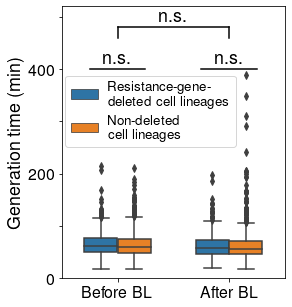

In [9]:
fig, ax = plt.subplots(1,1, figsize = (4,5))
sns.boxplot(x = 'Index', y = 'Generation_time', hue = 'cell', data = gene_time, width = 0.6, saturation = 0.8, ax = ax)
ax.set_xlabel('')
ax.set_ylabel('Generation time (min)',fontsize = 18.0)
data_list = [del_before,del_after,nondel_before,nondel_after]
stats1, pvalue1 = stat.mannwhitneyu(data_list[0],data_list[2])
if pvalue1 >0.01:
    ax.plot((-0.25,0.25),(400,400), color = 'black')
    ax.text(0.0,420,'n.s.',fontsize = 18, horizontalalignment='center', verticalalignment='center')
    print('Generation time before BL illumination is not significantly different (p-value is {:.3f}).\n'.format(pvalue1))
stats2, pvalue2 = stat.mannwhitneyu(data_list[1],data_list[3])
if pvalue2 >0.01:
    ax.plot((0.75,1.25),(400,400), color = 'black')
    ax.text(1.0,420,'n.s.',fontsize = 18, horizontalalignment='center', verticalalignment='center')
    print('Generation time after BL illumination is not significantly different (p-value is {:.3f}).\n'.format(pvalue2))
    
stats3, pvalue3 = stat.mannwhitneyu(pd.concat([data_list[0],data_list[2]]).to_numpy(),pd.concat([data_list[1],data_list[3]]).to_numpy())
if pvalue3 >0.01:
    ax.plot((0.0,1.0),(480,480), color = 'black')
    ax.plot((0.0,0.0),(480,460), color = 'black')
    ax.plot((1.0,1.0),(480,460), color = 'black')
    ax.text(0.5,500,'n.s.',fontsize = 18, horizontalalignment='center', verticalalignment='center')
    print('Generation time before and after BL illumination is not significantly different (p-value is {:.3f}).\n'.format(pvalue3))
ax.set_ylim(0,520)
ax.set_xlim(-0.5,1.5)
ax.legend(fontsize =13.5, bbox_to_anchor=(-0.015, 0.77), loc='upper left')
ax.set_yticks([0,100,200,300,400,500])
ax.set_yticklabels(['0','','200','','400',''])

plt.show()
#save_path = './Figure1E.pdf'
#plt.savefig(save_path,bbox_inches = 'tight', transparent = True)

## Figure S4

Comparison of elongation rates between no Cp condition and Cp conditions.

### search for data path

In [11]:
path = './single-cell_data'
path_list = glob.glob(os.path.join(path, '**/integrated'), recursive = True)
path_list = [x.replace('./single-cell_data','').replace('/integrated','') for x in path_list if '/deletion' in x]

### calculate elongation rates in no Cp and Cp condition.

No Cp condition corresponds to path_list[3].  
Cp condition corresponds to path_list[2]

In [12]:
elongation_rate = []
for k, branch_path in enumerate([path_list[3],path_list[2]]):

    ##Global variables
    BL_time_Cp_time_list = pd.read_csv('./BL_time_Cp_time_data.csv')
    BL_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(branch_path[-6:]), 'BL_time'].reset_index(drop = True)[0] ## slice number just after blue light exposure
    Cp_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(branch_path[-6:]), 'Cp_time'].reset_index(drop = True)[0] ## slice number just after Cp exposure
    if BL_time == 0:
        BL_time = Cp_time
    window = 1/12 ## averaged time window (1/12 is non-averaged window)

    ##Distinguish cell types
    image_path = path + branch_path
    Number = os.listdir(image_path + '/integrated')
    Number = [i for i in Number if 'Results' in i]
    for i in range(len(Number)):
        Number[i] = Number[i].lstrip('Results')
        Number[i] = Number[i].rstrip('.csv')

    Result_all = sc.Read_results_data(Number, dr = image_path)      
    ##Calculate normalised term
    norm = sc.Calculate_normalize_term(Result_all, BL_time = BL_time, dr = image_path)

    Result_gen = sc.Modify_generation_data(Result_all, BL_time)
    Result_gen.file = Result_gen.file.astype(str).str.zfill(4)

    res = Result_gen.copy()
    res_gen = res.groupby(['file', 'Division_number'], as_index = False).TxRed.mean().copy()
    res_gen.loc[:,'id_number'] = res.groupby(['file', 'Division_number'], as_index = False).id_number.mean().reset_index()['id_number']
    res_gen_time = pd.DataFrame({'Size':res.groupby(['file', 'Division_number'], as_index = False).size()}).reset_index()
    res_gen.loc[:,'Generation_time'] = res_gen_time['Size']*10
    res_gen['elongation_rate'] = res.groupby(['file', 'Division_number'], as_index = False).apply(sc.calculation_elongation_rate).reset_index()[0]

    elongation_rate += [res_gen.loc[(res_gen['Division_number']>0)&(res_gen['Division_number']<=10)&(res_gen['id_number']==2),'elongation_rate'].dropna()]

### plot and save figure

pvalue is also calculated and printed.

p-value is 0.634.



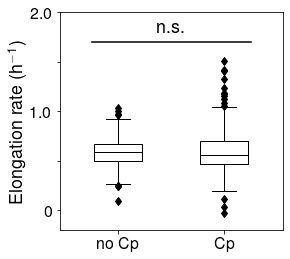

In [13]:
fig,ax = plt.subplots(ncols = 1, nrows = 1, figsize = (4,4))

stats, pvalue = stat.ttest_ind(elongation_rate[0],elongation_rate[1],equal_var = False)
if pvalue >0.01:
    ax.plot((1.25,1.75),(1.7,1.7), color = 'black')
    ax.text(1.5,1.85,'n.s.',fontsize = 18, horizontalalignment='center', verticalalignment='center')
print('p-value is {:.3f}.\n'.format(pvalue))

ax.boxplot(elongation_rate,positions = [4/3,5/3],medianprops=dict(color='black', linewidth=1),flierprops=dict(marker = 'd',markerfacecolor='black', markeredgecolor = 'black',linewidth=1))
ax.set_xticks([4/3,5/3])
ax.set_xticklabels(['no Cp','Cp'])
ax.set_yticks([0,0.5,1.0,1.5,2.0])
ax.set_yticklabels([0,'',1.0,'',2.0])
ax.set_ylabel('Elongation rate (h$^{-1}$)', fontsize = 18)
ax.set_ylim(-0.2,2)
ax.set_xlim(1.15,1.85)
plt.show()
#save_path = '.FigureS4.pdf'
#plt.savefig(save_path, transparent = True, bbox_inches = 'tight')
#plt.cla()

## Figure 2H, I and S5

### set variables

In [14]:
path_list = ['./single-cell_data/deletion_in_Cp/180726']
branch_path = path_list[0]
BL_time_Cp_time_list = pd.read_csv('./BL_time_Cp_time_data.csv')
BL_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(branch_path[-6:]), 'BL_time'].reset_index(drop = True)[0] ## slice number just after blue light exposure
Cp_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(branch_path[-6:]), 'Cp_time'].reset_index(drop = True)[0] ## slice number just after Cp exposure
if BL_time == 0:
    BL_time = Cp_time
window = 1/12 ## averaged time window (1/12 is non-averaged window)

### import the result data.
import and integrate the data in deletion experiment under Cp exposure.

In [15]:
image_path = branch_path
Number = os.listdir(image_path + '/integrated')
Number = [i for i in Number if 'Results' in i]
for i in range(len(Number)):
    Number[i] = Number[i].lstrip('Results')
    Number[i] = Number[i].rstrip('.csv')
Result_all = sc.Read_results_data(Number, dr = image_path)      

#Result_all = Result_all[(Result_all['Slice']<=BL_time-4)|(Result_all['Slice']>=BL_time)] #exclude the data during BL illumination
Result_gen = sc.Modify_generation_data(Result_all,BL_time)
Result_gen.file = Result_gen.file.astype(str).str.zfill(4)

### calculate the averaged fluorescence intensities of mCherry-CAT in each generation.
res_gen = Result_gen.groupby(['file', 'Division_number'], as_index = False).agg({'TxRed': 'mean'}).copy()
res_gen['id_number'] = Result_gen.groupby(['file', 'Division_number'], as_index = False).id_number.mean().reset_index()['id_number']

### calculate the generation time in each generation.
res_gen_time = pd.DataFrame({'Size':Result_gen.groupby(['file', 'Division_number'], as_index = False).size()}).reset_index()
res_gen.loc[:,'Generation_time'] = res_gen_time['Size']/6

### Distinguish the total data by cell type

"id_number = 0" represents resistance-gene-deleted cell lineages.\n
"id_number = 2" represents non-deleted cell lineages.

In [16]:
generation0 = res_gen[res_gen['id_number']==0].groupby('Division_number').Generation_time.describe().reset_index()
generation0 = generation0[generation0['count'] >= np.max(generation0['count'])/5.0]
generation2 = res_gen[res_gen['id_number']==2].groupby('Division_number').Generation_time.describe().reset_index()
generation2 = generation2[generation2['count'] >= np.max(generation2['count'])/5.0]

TxRed0 = res_gen[res_gen['id_number']==0].groupby('Division_number').TxRed.describe().reset_index()
TxRed0 = TxRed0[TxRed0['count'] >= np.max(TxRed0['count'])/5.0]
TxRed2 = res_gen[res_gen['id_number']==2].groupby('Division_number').TxRed.describe().reset_index()
TxRed2 = TxRed2[TxRed2['count'] >= np.max(TxRed2['count'])/5.0]

### plot figure and save

(left) Transitions of fluorescence intensities of mCherry-CAT corresponding to Fig. 2H.
(right) Transitions of generation time corresponding to Fig. 2I.TxRed2

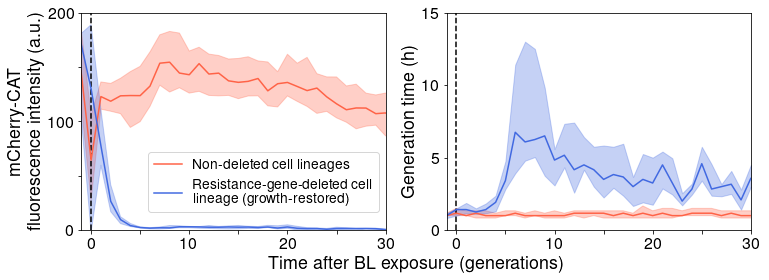

In [17]:
label_list = ['Resistance-gene-deleted cell \nlineage (growth-restored)', 'Non-deleted cell lineages']
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (12,4))

### plot transitions of fluorescence intensities
axes[0].plot(TxRed2['Division_number'], TxRed2['50%'], color = 'tomato',label = label_list[1])
axes[0].fill_between(TxRed2['Division_number'], TxRed2['25%'], TxRed2['75%'], color = 'tomato', alpha = 0.3)
axes[0].plot(TxRed0['Division_number'], TxRed0['50%'], color = 'royalblue',label = label_list[0])
axes[0].fill_between(TxRed0['Division_number'], TxRed0['25%'], TxRed0['75%'], color = 'royalblue', alpha = 0.3)
axes[0].set_ylabel('mCherry-CAT\nfluorescence intensity (a.u.)', fontsize = 18)
axes[0].vlines(0,0,200,linestyle = 'dashed')
axes[0].legend(fontsize = 14, loc = 'lower right', bbox_to_anchor = (1.00,0.05))
axes[0].set_xlim(-1,30)
axes[0].set_ylim(0,200)
axes[0].set_xticks([0,5,10,15,20,25,30])
axes[0].set_xticklabels([0,'',10,'',20,'',30])
axes[0].set_yticks([0,50,100,150,200])
axes[0].set_yticklabels([0,'',100,'',200])

### plot transitions of generation time
axes[1].plot(generation2['Division_number'], generation2['50%'], color = 'tomato',label = label_list[1])
axes[1].fill_between(generation2['Division_number'], generation2['25%'], generation2['75%'], color = 'tomato', alpha = 0.3)
axes[1].plot(generation0['Division_number'], generation0['50%'], color = 'royalblue',label = label_list[0])
axes[1].fill_between(generation0['Division_number'], generation0['25%'], generation0['75%'], color = 'royalblue', alpha = 0.3)
axes[1].set_ylabel('Generation time (h)', fontsize = 18)
axes[1].vlines(0,0,15,linestyle = 'dashed')
axes[1].set_xlim(-1,30)
axes[1].set_ylim(0,15)
axes[1].set_xticks([0,5,10,15,20,25,30])
axes[1].set_xticklabels([0,'',10,'',20,'',30])
axes[1].set_yticks([0,5,10,15])
axes[1].set_yticklabels([0,5,10,15])

fig.add_subplot(111, frameon=False)
### hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time after BL exposure (generations)', fontsize = 18)
plt.show()
#save_path = './Figure_2_H-I.pdf'
#plt.savefig(save_path, transparent = True, bbox_inches = 'tight')
#plt.cla

### caluculate elongation rates and distinguish the cell type.

In [18]:
res_gen['elongation_rate'] = Result_gen.groupby(['file', 'Division_number'], as_index = False).apply(sc.calculation_elongation_rate).reset_index()[0]
        
elongation0 = res_gen[res_gen['id_number']==0].groupby('Division_number').elongation_rate.describe().reset_index()
elongation0 = elongation0[elongation0['count'] >= np.max(elongation0['count'])/5.0]
elongation2 = res_gen[res_gen['id_number']==2].groupby('Division_number').elongation_rate.describe().reset_index()
elongation2 = elongation2[elongation2['count'] >= np.max(elongation2['count'])/5.0]

### plot and save figure

Transitions of elonegation rates in deletion experiment under Cp exposure, corresponding to Fig. S5.

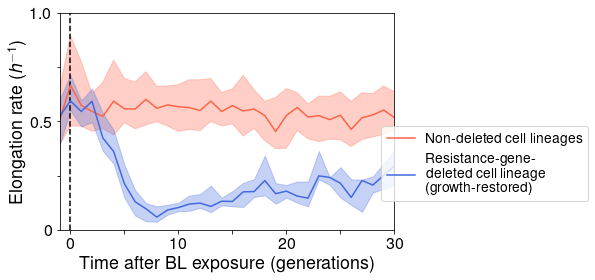

In [19]:
label_list = ['Resistance-gene-\ndeleted cell lineage \n(growth-restored)', 'Non-deleted cell lineages']
fig, axes = plt.subplots(ncols = 1, nrows = 1, figsize = (6,4))

axes.plot(elongation2['Division_number'], elongation2['50%'], color = 'tomato',label = label_list[1])
axes.fill_between(elongation2['Division_number'], elongation2['25%'], elongation2['75%'], color = 'tomato', alpha = 0.3)
axes.plot(elongation0['Division_number'], elongation0['50%'], color = 'royalblue',label = label_list[0])
axes.fill_between(elongation0['Division_number'], elongation0['25%'], elongation0['75%'], color = 'royalblue', alpha = 0.3)

axes.set_xlabel('Time after BL exposure (generations)', fontsize = 18)
axes.set_ylabel('Elongation rate ($h^{-1}$)', fontsize = 18)
axes.vlines(0,0,1,linestyle = 'dashed')
axes.legend(fontsize = 14, loc = 'lower right', bbox_to_anchor = (1.6,0.1))
axes.set_xlim(-1,30)
axes.set_ylim(0,1)
axes.set_xticks([0,5,10,15,20,25,30])
axes.set_xticklabels([0,'',10,'',20,'',30])
axes.set_yticks([0,0.25,0.50,0.75,1.00])
axes.set_yticklabels([0,'',0.5,'',1.0])
plt.show()

#save_path = './Figure_S5.pdf'
#plt.savefig(save_path, transparent = True, bbox_inches = 'tight')
#plt.cla

## Figure S10

### set variables

In [20]:
path_list = ['./single-cell_data/ribosome_reporter/YK0136/191214']
branch_path = path_list[0]
BL_time_Cp_time_list = pd.read_csv('./BL_time_Cp_time_data.csv')
BL_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(branch_path[-6:]), 'BL_time'].reset_index(drop = True)[0] ## slice number just after blue light exposure
Cp_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(branch_path[-6:]), 'Cp_time'].reset_index(drop = True)[0] ## slice number just after Cp exposure
if BL_time == 0:
    BL_time = Cp_time
window = 1/12 ## averaged time window (1/12 is non-averaged window)

### import data

import and integrate the single-cell result in deletion experiment with ribosome reporter strain.

In [21]:
image_path = branch_path
Number = os.listdir(image_path + '/integrated')
Number = [i for i in Number if 'Results' in i]
for i in range(len(Number)):
    Number[i] = Number[i].lstrip('Results')
    Number[i] = Number[i].rstrip('.csv')
Result_all = sc.Read_results_data(Number, dr = image_path) 
###Calculate normalised term
norm = sc.Calculate_normalize_term(Result_all, BL_time = BL_time, dr = image_path)

#Result_all = Result_all[(Result_all['Slice']<=BL_time-4)|(Result_all['Slice']>=BL_time)] #exclude the data during BL illumination
Result_gen = sc.Modify_generation_data(Result_all,BL_time)
Result_gen.file = Result_gen.file.astype(str).str.zfill(4)

### calculate the averaged fluorescence intensities of mCherry-CAT in each generation.
res_gen = Result_gen.groupby(['file', 'Division_number'], as_index = False).agg({'TxRed': 'mean','YFP': 'mean'}).copy()
res_gen['id_number'] = Result_gen.groupby(['file', 'Division_number'], as_index = False).id_number.mean().reset_index()['id_number']

### calculate the generation time in each generation.
res_gen_time = pd.DataFrame({'Size':Result_gen.groupby(['file', 'Division_number'], as_index = False).size()}).reset_index()
res_gen.loc[:,'Generation_time'] = res_gen_time['Size']/6
res_gen['elongation_rate'] = Result_gen.groupby(['file', 'Division_number'], as_index = False).apply(sc.calculation_elongation_rate).reset_index()[0]
res_gen['fluorescence_ratio'] = res_gen['TxRed']/(res_gen['YFP']*norm)

### distinguish cell types

"id_number = 0" represents resistantce-gene-deleted cell lineages.
"id_number = 2" denotes non-deleted cell lineages.

In [22]:
generation0 = res_gen[res_gen['id_number']==0].groupby('Division_number').Generation_time.describe().reset_index()
generation0 = generation0[generation0['count'] >= np.max(generation0['count'])/5.0]
generation2 = res_gen[res_gen['id_number']==2].groupby('Division_number').Generation_time.describe().reset_index()
generation2 = generation2[generation2['count'] >= np.max(generation2['count'])/5.0]

ratio0 = res_gen[res_gen['id_number']==0].groupby('Division_number').fluorescence_ratio.describe().reset_index()
ratio0 = ratio0[ratio0['count'] >= np.max(ratio0['count'])/5.0]
ratio2 = res_gen[res_gen['id_number']==2].groupby('Division_number').fluorescence_ratio.describe().reset_index()
ratio2 = ratio2[ratio2['count'] >= np.max(ratio2['count'])/5.0]

### plot and save figure

(left) Transitions of generation time (right) Transition of fluorescence ratio (RplS-mCherry/RpsB-mVenus)

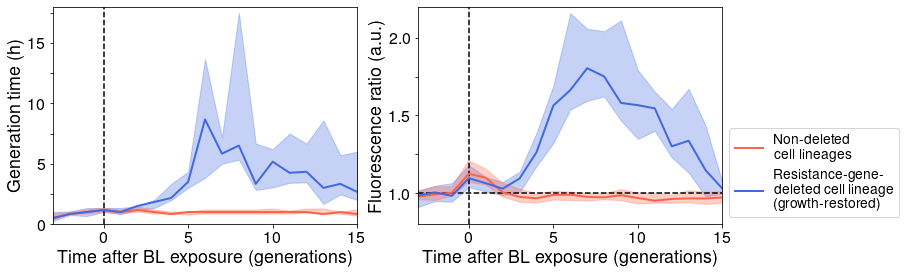

In [23]:
label_list = ['Resistance-gene-\ndeleted cell lineage \n(growth-restored)', 'Non-deleted \ncell lineages ']
fig, axes = plt.subplots(ncols = 2, nrows = 1,figsize = (12,4))

generation2.plot(x = 'Division_number', y = '50%', ax = axes[0], color = 'tomato', lw = 2, label = label_list[1])
generation0.plot(x = 'Division_number', y = '50%', ax = axes[0], color = 'royalblue', lw = 2, label = label_list[0])
axes[0].fill_between(generation0[generation0['count']>=np.max(generation0['count'])/5.0]['Division_number'],generation0[generation0['count']>=np.max(generation0['count'])/5.0]['25%'],generation0[generation0['count']>=np.max(generation0['count'])/5.0]['75%'],color = 'royalblue', alpha = 0.3)
axes[0].fill_between(generation2['Division_number'],generation2['25%'],generation2['75%'],color = 'tomato', alpha = 0.3)
axes[0].vlines(0,0,218,linestyle = 'dashed')
# axes[0].hlines(1.0,-3,20,linestyle = 'dashed')

axes[0].set_yticks([0,2.5,5,7.5,10,12.5,15,17.5,20])
axes[0].set_yticklabels([0,'',5,'',10,'',15,'',20])
axes[0].set_xticks([0,5,10,15,20])
axes[0].set_xticklabels([0,5,10,15,20])
axes[0].set_xlim(-3,15)
axes[0].set_ylim(0,18)
axes[0].set_xlabel('Time after BL exposure (generations)', fontsize = 18)
axes[0].set_ylabel('Generation time (h)',fontsize = 18)

ratio2.plot(x = 'Division_number',y = '50%',ax = axes[1],color = 'tomato',lw = 2, label = label_list[1])
ratio0.plot(x = 'Division_number',y = '50%',ax = axes[1],color = 'royalblue',lw = 2, label = label_list[0])
axes[1].fill_between(ratio0[ratio0['count']>=np.max(ratio0['count'])/5.0]['Division_number'],ratio0[ratio0['count']>=np.max(ratio0['count'])/5.0]['25%'],ratio0[ratio0['count']>=np.max(ratio0['count'])/5.0]['75%'],color = 'royalblue', alpha = 0.3)
axes[1].fill_between(ratio2['Division_number'],ratio2['25%'],ratio2['75%'],color = 'tomato', alpha = 0.3)
axes[1].vlines(0,0.8,2.2,linestyle = 'dashed')
axes[1].hlines(1.0,-3,20,linestyle = 'dashed')

axes[1].set_xticks([0,5,10,15,20])
axes[1].set_xticklabels([0,5,10,15,20])
axes[1].set_yticks([1.0,1.25,1.5,1.75,2.0])
axes[1].set_yticklabels([1.0,'',1.5,'',2.0])
axes[1].set_xlim(-3,15)
axes[1].set_ylim(0.8,2.2)
axes[1].legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize = 14)
axes[1].set_xlabel('Time after BL exposure (generations)', fontsize = 18)
axes[1].set_ylabel('Fluorescence ratio (a.u.)',fontsize = 18)
axes[0].get_legend().remove()

plt.show()
#save_path = './Figure_S10.pdf'
#plt.savefig(save_path, transparent = True, bbox_inches = 'tight')
#plt.cla()